<a href="https://colab.research.google.com/github/zobayer-al-mahmud/Object_Tracking_and_Heatmap_Visualization/blob/main/People_Flow_Detection_using_Object_Tracking_%26_Heatmap_Visualization_(Zobayer_Al_Mahmud).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Import Libraries**

In [ ]:
!pip install ultralytics -q


In [ ]:
from ultralytics import YOLO
import cv2
import numpy as np
import os
import time

# Load YOLOv8 model
model = YOLO('yolov8x.pt')
print("✅ YOLOv8x model loaded")

# Video input
video_path = "/content/people-walking.mp4"
cap = cv2.VideoCapture(video_path)

width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
video_fps = cap.get(cv2.CAP_PROP_FPS)

# Output path setup
output_dir = "outputs"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "annotated_video_tracked.mp4")

# Video writer
out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), video_fps, (width, height))

# Line coordinates
top_line = np.array([[15, 367], [1919, 367]])
bottom_line = np.array([[15, 623], [1910, 605]])
top_y = int(np.mean(top_line[:, 1]))
bottom_y = int(np.mean(bottom_line[:, 1]))

# Counters and trackers
id_positions = {}
id_states = {}  # 'default', 'in', 'out'
in_count = 0
out_count = 0
frame_count = 0
tracker = 'bytetrack.yaml'

# FPS timer
prev_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1
    start_time = time.time()

    # Detection + tracking (only person class)
    results = model.track(frame, classes=[0], persist=True, tracker=tracker, verbose=False)
    boxes = results[0].boxes.xyxy.tolist()
    track_ids = results[0].boxes.id.int().tolist() if results[0].boxes.id is not None else []

    current_ids = set()

    # Draw lines
    cv2.line(frame, tuple(top_line[0]), tuple(top_line[1]), (255, 0, 0), 2)
    cv2.line(frame, tuple(bottom_line[0]), tuple(bottom_line[1]), (0, 0, 255), 2)

    for box, track_id in zip(boxes, track_ids):
        x1, y1, x2, y2 = map(int, box)
        cx, cy = (x1 + x2) // 2, (y1 + y2) // 2
        current_ids.add(track_id)

        # Determine default color (white), unless state is "in" or "out"
        color = (255, 255, 255)  # default white

        if track_id in id_positions:
            prev_y = id_positions[track_id]

            # Crossed top line downward → IN
            if prev_y < top_y and cy >= top_y and id_states.get(track_id) != "in":
                in_count += 1
                id_states[track_id] = "in"
                print(f"IN: ID {track_id}")

            # Crossed bottom line upward → OUT
            elif prev_y > bottom_y and cy <= bottom_y and id_states.get(track_id) != "out":
                out_count += 1
                id_states[track_id] = "out"
                print(f"OUT: ID {track_id}")

        # Update y-position for this ID
        id_positions[track_id] = cy

        # Set color based on state
        if id_states.get(track_id) == "in":
            color = (0, 255, 0)  # Green
        elif id_states.get(track_id) == "out":
            color = (0, 0, 255)  # Red

        # Draw box and ID
        cv2.rectangle(frame, (x1, y1), (x2, y2), color, 2)
        cv2.putText(frame, f"ID: {track_id}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.circle(frame, (cx, cy), 5, color, -1)

    # Remove lost IDs from memory
    lost_ids = set(id_positions.keys()) - current_ids
    for lost_id in lost_ids:
        id_positions.pop(lost_id, None)
        id_states.pop(lost_id, None)

    # FPS calculation
    curr_time = time.time()
    fps = 1 / (curr_time - prev_time)
    prev_time = curr_time

    # Annotate frame
    cv2.putText(frame, f"IN: {in_count}", (20, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(frame, f"OUT: {out_count}", (20, 90),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
    cv2.putText(frame, f"Total in frame: {len(current_ids)}", (20, 140),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cv2.putText(frame, f"Frame: {frame_count}", (20, 190),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    cv2.putText(frame, f"FPS: {fps:.2f}", (20, 240),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    out.write(frame)

cap.release()
out.release()

print(f"✅ Processing complete! Video saved at: {output_path}")
print(f"Total IN: {in_count}, Total OUT: {out_count}")


✅ YOLOv8x model loaded
IN: ID 18
OUT: ID 2
OUT: ID 30
IN: ID 11
IN: ID 25
IN: ID 27
IN: ID 19
OUT: ID 7
IN: ID 20
IN: ID 51
OUT: ID 80
IN: ID 9
OUT: ID 102
OUT: ID 103
IN: ID 75
IN: ID 79
IN: ID 214
OUT: ID 181
IN: ID 33
✅ Processing complete! Video saved at: outputs/annotated_video_tracked.mp4
Total IN: 12, Total OUT: 7


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO
from tqdm import tqdm

# Load YOLOv8 model (make sure you have yolov8n.pt or use another)
model = YOLO('yolov8n.pt')

# Input/output paths
video_path = '/content/people-walking.mp4'  # Replace with your video
output_video_path = 'output_with_trail.mp4'
output_image_path = 'final_heatmap_image.png'

# Initialize video
cap = cv2.VideoCapture(video_path)
if not cap.isOpened():
    raise IOError("❌ Cannot open video file.")

# Get frame size
ret, frame = cap.read()
if not ret or frame is None:
    raise ValueError("❌ Could not read frame from video.")

height, width = frame.shape[:2]
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, cap.get(cv2.CAP_PROP_FPS), (width, height))

# Heatmap canvas for trail (float for accumulation)
heatmap_canvas = np.zeros((height, width), dtype=np.float32)

# Alpha for fading trail
fade_alpha = 0.95

# Loop through video
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

for _ in tqdm(range(frame_count), desc="Processing video"):
    ret, frame = cap.read()
    if not ret:
        break

    # Run YOLOv8 detection
    results = model(frame, verbose=False)[0]

    # Get person detections only
    for box in results.boxes:
        cls_id = int(box.cls)
        if cls_id != 0:  # Class 0 = person
            continue

        x1, y1, x2, y2 = map(int, box.xyxy[0])
        cx = int((x1 + x2) / 2)
        cy = int((y1 + y2) / 2)

        # Accumulate center position on heatmap
        cv2.circle(heatmap_canvas, (cx, cy), 8, 1, -1)

        # Draw bounding box and center
        cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)
        cv2.circle(frame, (cx, cy), 4, (0, 255, 255), -1)

    # Normalize and colorize the heatmap
    temp_heatmap = np.clip(heatmap_canvas, 0, 255)
    temp_heatmap = cv2.GaussianBlur(temp_heatmap, (31, 31), 0)
    heatmap_color = cv2.applyColorMap(temp_heatmap.astype(np.uint8), cv2.COLORMAP_JET)

    # Fade the trail slightly
    heatmap_canvas *= fade_alpha

    # Blend heatmap over original frame
    overlay = cv2.addWeighted(frame, 0.7, heatmap_color, 0.5, 0)

    # Write frame
    out.write(overlay)

# Save final heatmap image
final_heatmap = cv2.applyColorMap(
    cv2.GaussianBlur(np.clip(heatmap_canvas, 0, 255).astype(np.uint8), (51, 51), 0),
    cv2.COLORMAP_JET
)
cv2.imwrite(output_image_path, final_heatmap)

# Release everything
cap.release()
out.release()
cv2.destroyAllWindows()

print(f"✅ Heatmap video saved as: {output_video_path}")
print(f"✅ Heatmap image saved as: {output_image_path}")


Processing video: 100%|██████████| 341/341 [00:33<00:00, 10.18it/s]


✅ Heatmap video saved as: output_with_trail.mp4
✅ Heatmap image saved as: final_heatmap_image.png


In [ ]:
import cv2
import numpy as np
from ultralytics import YOLO

# === CONFIG ===
video_path = '/content/people-walking.mp4'   # Input video path
output_heatmap_video = 'heatmap_output.mp4'  # Output heatmap video
output_image_path = '/content/final_heatmap.jpg'      # Output final heatmap image
model_path = 'yolov8n.pt'                    # YOLOv8 model (people only)
conf_threshold = 0.3                         # Confidence threshold

# === LOAD MODEL ===
model = YOLO(model_path)

# === VIDEO SETUP ===
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()
if not ret:
    raise ValueError("⚠️ Could not read from video.")

H, W = frame.shape[:2]
heatmap_canvas = np.zeros((H, W), dtype=np.float32)

# === OUTPUT VIDEO SETUP ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_heatmap_video, fourcc, 30.0, (W, H))

# === PROCESS VIDEO FRAMES ===
while ret:
    # Run YOLOv8 inference
    results = model(frame, verbose=False)[0]

    # Filter only 'person' detections (class=0)
    for box in results.boxes:
        cls_id = int(box.cls[0])
        conf = float(box.conf[0])
        if cls_id == 0 and conf > conf_threshold:
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            cx = int((x1 + x2) / 2)
            cy = int((y1 + y2) / 2)

            # Accumulate heat around the center
            cv2.circle(heatmap_canvas, (cx, cy), radius=20, color=3, thickness=-1)

            # Optional: Show bounding box for people
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 255, 255), 2)

    # Create real-time heatmap overlay
    temp_map = np.clip(heatmap_canvas * 15, 0, 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(temp_map, (31, 31), 0)
    colored_map = cv2.applyColorMap(blurred, cv2.COLORMAP_JET)

    # Overlay heatmap on frame
    overlay = cv2.addWeighted(frame, 0.6, colored_map, 0.4, 0)

    # Write to output video
    out.write(overlay)

    # Read next frame
    ret, frame = cap.read()

cap.release()
out.release()

# === FINAL HEATMAP IMAGE ===
# Normalize and amplify final heatmap
amplified_heatmap = np.clip(heatmap_canvas * 15, 0, 255)
normalized_heatmap = cv2.normalize(amplified_heatmap, None, 0, 255, cv2.NORM_MINMAX)
blurred_heatmap = cv2.GaussianBlur(normalized_heatmap.astype(np.uint8), (31, 31), 0)
colored_heatmap = cv2.applyColorMap(blurred_heatmap, cv2.COLORMAP_JET)

# Save final heatmap image
cv2.imwrite(output_image_path, colored_heatmap)
print(f"✅ Final heatmap image saved: {output_image_path}")
print(f"✅ Heatmap video saved: {output_heatmap_video}")


✅ Final heatmap image saved: /content/final_heatmap.jpg
✅ Heatmap video saved: heatmap_output.mp4


Final Heatmap Image:


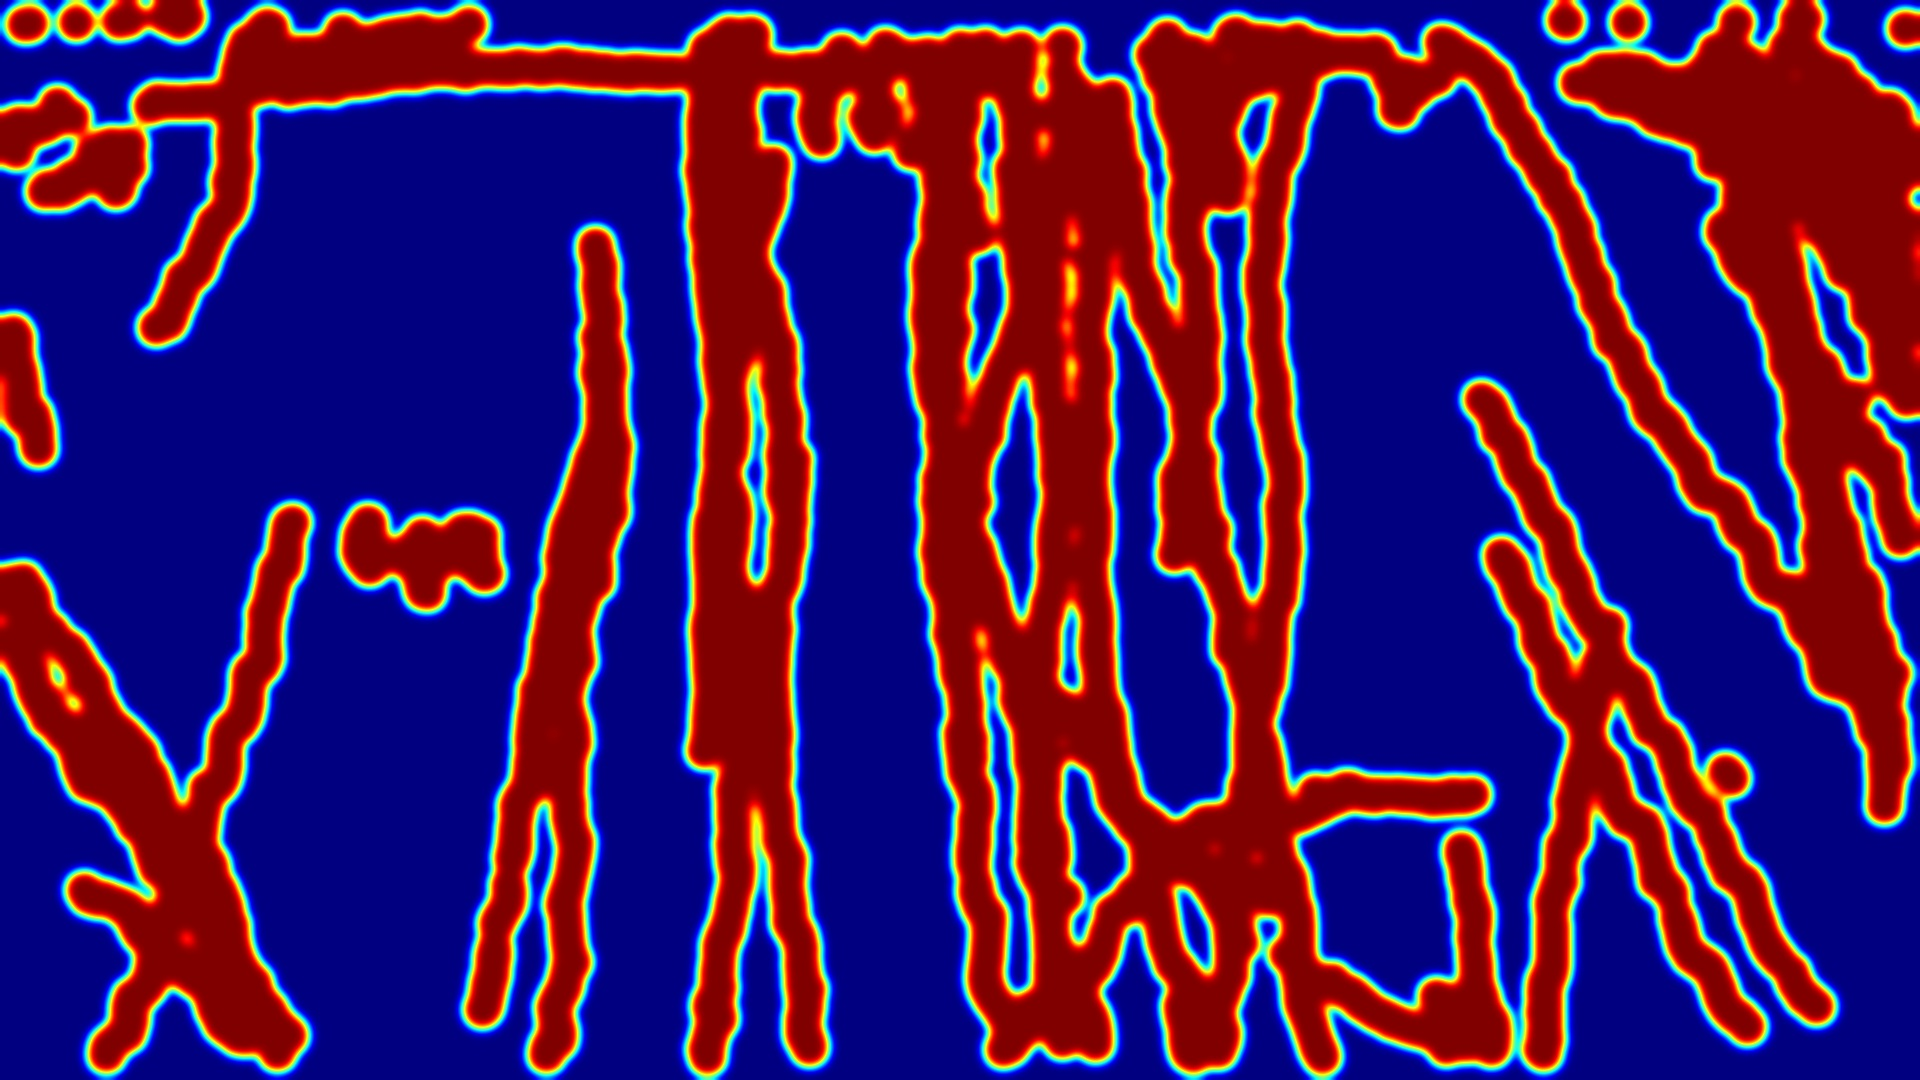

In [ ]:
from IPython.display import Image, display

print("Final Heatmap Image:")
display(Image('final_heatmap.jpg'))

# People Tracking and Counting

This project demonstrates how to track people in a video using YOLOv8 and count them as they cross predefined lines, indicating entry ("IN") or exit ("OUT").

## Detection Method

The project utilizes the YOLOv8 object detection model (`yolov8x.pt` or `yolov8n.pt`) to identify instances of people in each frame of the video.

Following detection, the ByteTrack algorithm is employed to assign unique tracking IDs to each detected person and maintain their identity across consecutive frames. This allows us to follow the movement of individual people.

## Line Coordinates

Two horizontal lines are defined in the video frame to act as virtual gates for counting:

*   **Top Line:** `[[15, 367], [1919, 367]]`
*   **Bottom Line:** `[[15, 623], [1910, 605]]`

These coordinates represent the `[x, y]` positions of the start and end points of the lines. The average y-coordinate of each line is used as the threshold for determining when a person crosses the line.

## Logic for IN/OUT Counting

The counting logic is based on tracking the vertical movement of the center point of each person's bounding box relative to the predefined lines:

1.  **Tracking Position:** The y-coordinate of the center of the bounding box for each tracked person ID is stored in the `id_positions` dictionary for the current frame.
2.  **State Tracking:** The state of each tracked person ID is maintained in the `id_states` dictionary ('default', 'in', or 'out').
3.  **Crossing Detection:**
    *   **"IN" Count:** A person is counted as "IN" if their previous y-position (`prev_y`) was *above* the `top_y` line and their current y-position (`cy`) is *at or below* the `top_y` line, and their state is not already "in".
    *   **"OUT" Count:** A person is counted as "OUT" if their previous y-position (`prev_y`) was *below* the `bottom_y` line and their current y-position (`cy`) is *at or above* the `bottom_y` line, and their state is not already "out".
4.  **State Update:** Once a person crosses a line and is counted, their state in `id_states` is updated to prevent double-counting for the same crossing event.
5.  **Lost IDs:** Tracked IDs that are no longer detected in the current frame are removed from the `id_positions` and `id_states` dictionaries to manage memory.

The final "IN" and "OUT" counts are displayed after processing the entire video.


# **Output Videos Link :** https://drive.google.com/drive/folders/1-W52X5Dio2gx7tZdJnbwwmsAgWEdsXUh?usp=sharing